In [1]:
import pandas as pd
import numpy as np
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sparshchandra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# The following script loads the CSV file containing the dataset into a Pandas dataframe. 
# This script displays the general format of the dataframe along with the first five rows.

In [2]:
dataset = pd.read_csv("Consumer_Complaints.csv")
print(dataset.shape)
dataset.head()

(1025010, 19)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,03-12-2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,10-01-2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,06-08-2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [ ]:
# The result reveals that there are over a million entries in the dataset, organized into 19 columns.

# Only product complaints from actual customers are of relevance to us. 
# We do this by just keeping the columns for "Consumer Complaint" and "Product," while discarding the rest.

In [3]:
complaints_df = dataset.filter(["Consumer Complaint", "Product"], axis = 1)
complaints_df.head()

,Consumer Complaint,Product
0,NaN,Mortgage
1,I have outdated information on my credit repor...,Credit reporting
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
3,NaN,Credit card
4,NaN,Debt collection


In [ ]:
# Data Analysis and Preprocessing
# Data cleansing, also known as preparation, is a frequent job when dealing with huge datasets. 
# This dataset will serve as an example for us to demonstrate. 
# Use this script to see how many records in our Consumer Complaint and Product columns are lacking data. 
# According to the results, there are 747196 blanks in the Consumer Complaint column.

In [4]:
complaints_df.isnull().sum()


Consumer Complaint    747196
Product                    0
dtype: int64

In [ ]:
# The entries in our dataset that have missing or empty values will be deleted. 
# The following code snippet shows how to use the dropna() method in Pandas to get rid of all null values. 
# The result verifies that neither column was missing any data after the nulls were removed.

In [5]:
complaints_df.dropna(inplace=True)
print(complaints_df.shape)
complaints_df.isnull().sum()

(277814, 2)


Consumer Complaint    0
Product               0
dtype: int64

In [ ]:
# Due to time and storage restrictions, we will only use the first 100,000 records in our dataset to 
# develop and evaluate our model. 

# Let's look at how the first 100,000 recordings break out in terms of the 
# kind of products people are complaining about.

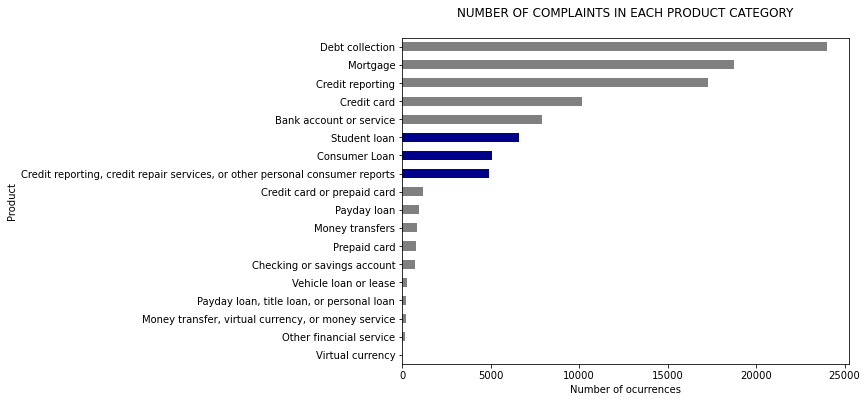

In [6]:
complaints_df = complaints_df[:100000]
complaints_df.rename(columns={'Consumer Complaint': 'Consumer_Complaint'}, inplace=True)
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
complaints_df.groupby('Product').Consumer_Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [ ]:
# Based on the data above, it seems that debt collection is the most common source of customer dissatisfaction, 
# followed by mortgages and credit reports.

# The next thing we need to do is make sure all of our text inputs are the same. 
# The process involves first converting the input text to lowercase and then removing any special
# characters or single characters that may be present. These actions are executed by the clean text() function, 
# which is defined and called in the subsequent script.

In [7]:
def clean_text(text):

    complaints = []

    for comp in text:
        # remove special characters
        comp = re.sub(r'\W', ' ', str(comp))

        # remove single characters
        comp  = re.sub(r'\s+[a-zA-Z]\s+', ' ', comp )

        # Remove single characters from the beginning
        comp  = re.sub(r'\^[a-zA-Z]\s+', ' ', comp)

        # Converting to Lowercase
        comp  = comp.lower()

        complaints.append(comp)

    return complaints

complaints = clean_text(list(complaints_df['Consumer_Complaint']))

In [8]:
complaints_df['category_id'] = complaints_df['Product'].factorize()[0]
category_id_df = complaints_df[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
complaints_df.head()

,Consumer_Complaint,Product,category_id
1,I have outdated information on my credit repor...,Credit reporting,0
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan,1
7,An account on my credit report has a mistaken ...,Credit reporting,0
12,This company refuses to provide me verificatio...,Debt collection,2
16,This complaint is in regards to Square Two Fin...,Debt collection,2


In [ ]:
# Our last step is to transform the textual complaints we've received and the product categories 
# we've identified as a result into their corresponding quantitative equivalents. 
# Since machine learning models only understand numeric data, this is essential.

# Converting text strings to numbers may be done in a variety of ways. 
# We'll be using the TFIDF method, which only accounts for the existence of words while translating text to numbers, 
# in this guide.

# The TfidfVectorizer class included in the sklearn.feature extraction.text package may be used to put this strategy 
# into action. The following is an illustration of this procedure:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfid_conv = TfidfVectorizer(max_features=3000, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
# X = tfid_conv.fit_transform(complaints).toarray()
tfidf = TfidfVectorizer(max_features=3000, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))

# We transform each complaint into a vector
features = tfidf.fit_transform(complaints_df.Consumer_Complaint).toarray()

labels = complaints_df.category_id

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
X = complaints_df['Consumer_Complaint'] # Collection of documents
y = complaints_df['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Our sklearn employee attrition model was trained with the Random Forest Classifier, so we'll be utilizing 
# the same classifier to train our text classification model. 

# Our model may be trained by calling the sklearn.ensemble module's fit() method on the 
# RandomForestClassifier class. The predict() function can be used for forecasting. 
# It could take some time for the following block to finish running because it trains our machine learning model.

In [ ]:
models = [
    LogisticRegression(random_state=0,max_iter=1000),
    LinearSVC(),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    MultinomialNB()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [37]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.78491,0.001461
LogisticRegression,0.78795,0.002011
MultinomialNB,0.75023,0.000856
RandomForestClassifier,0.51563,0.003154


In [50]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               complaints_df.index, test_size=0.25, 
                                                               random_state=1)
k_nn=KNeighborsClassifier(n_neighbors=500)
k_nn.fit(X_train, y_train) 

y_pred = k_nn.predict(X_test)

In [51]:
print(metrics.classification_report(y_test,y_pred, zero_division=0))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.85      0.71      4354
           1       0.75      0.33      0.46      1237
           2       0.79      0.81      0.80      6172
           3       0.75      0.93      0.83      4652
           4       0.65      0.73      0.69      2519
           5       0.00      0.00      0.00        37
           6       0.69      0.67      0.68      1999
           7       0.83      0.78      0.81      1604
           8       0.58      0.30      0.39       188
           9       1.00      0.02      0.05       242
          10       0.87      0.10      0.17       207
          11       0.00      0.00      0.00        53
          12       0.62      0.01      0.01      1162
          13       0.00      0.00      0.00       173
          14       0.00      0.00      0.00        74
          15       0.00      0.00      0.00       267
          16       0.00      0.00      0.00         2
          17       0.00    

In [23]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               complaints_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= complaints_df['Product'].unique()))

				CLASSIFICATIION METRICS

                                                                              precision    recall  f1-score   support

                                                            Credit reporting       0.76      0.82      0.79      4354
                                                               Consumer Loan       0.69      0.61      0.65      1237
                                                             Debt collection       0.80      0.88      0.84      6172
                                                                    Mortgage       0.91      0.95      0.93      4652
                                                                 Credit card       0.73      0.81      0.77      2519
                                                     Other financial service       1.00      0.08      0.15        37
                                                     Bank account or service       0.75      0.80      0.77      1999
                          

/Users/muzaffar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muzaffar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muzaffar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


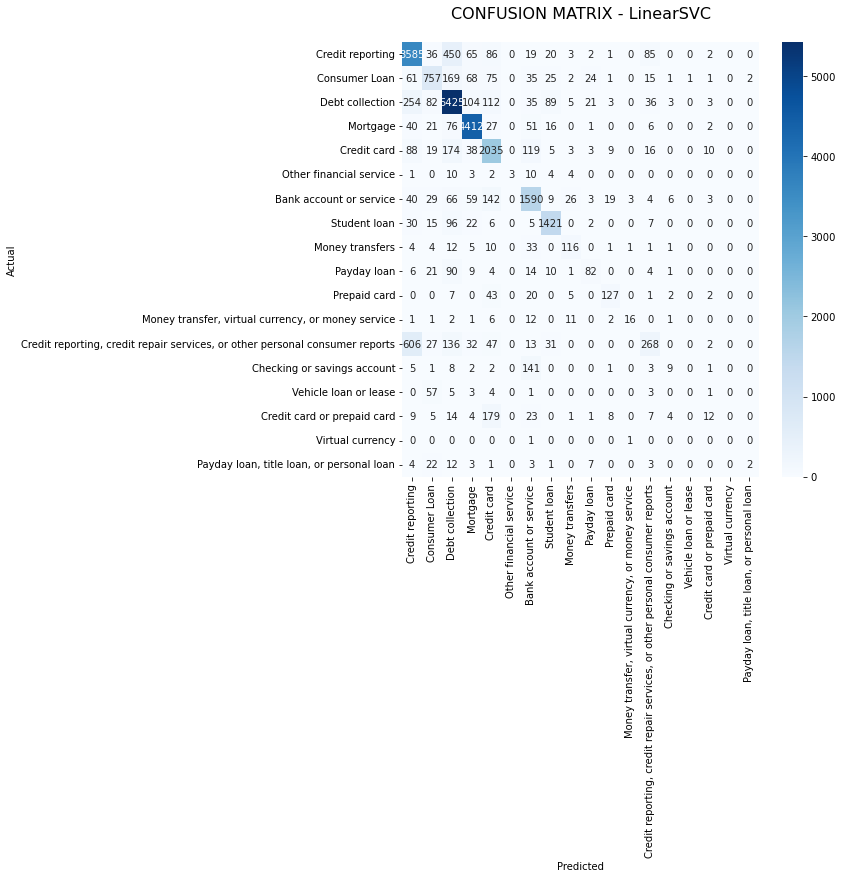

In [26]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(max_features=3000, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [29]:
new_complaint = """I re-enrolled at XXXX XXXX University in the XX/XX/XXXX time period. In the past month, Navient has hounded me on a regular basis. I have faxed them documents including all they required. I continue to receive phone calls for payments. In addition, Navient is now sending my late payment to the credit bureaus. Navient must now get their act together to prevent me from pursuing further action. I have been enrolled the entire time, and my deferral should be legitimate with a graduation date of XX/XX/XXXX as scheduled."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))


['Student loan']


In [ ]:
# Lets check another complaint

In [30]:
new_complaint_2 = """As part of their latest data breach, Equifax divulged my personal information without my authorization.
In addition, they delayed the release of the report and even permitted their higher management to sell off stock prior to the release."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting']


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(max_features=3000, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
k_nn=KNeighborsClassifier(n_neighbors=500)
model1 = k_nn.fit(tfidf_vectorizer_vectors, y_train) 

In [47]:
new_complaint = """I re-enrolled at XXXX XXXX University in the XX/XX/XXXX time period. In the past month, Navient has hounded me on a regular basis. I have faxed them documents including all they required. I continue to receive phone calls for payments. In addition, Navient is now sending my late payment to the credit bureaus. Navient must now get their act together to prevent me from pursuing further action. I have been enrolled the entire time, and my deferral should be legitimate with a graduation date of XX/XX/XXXX as scheduled."""
print(model1.predict(fitted_vectorizer.transform([new_complaint])))


['Student loan']


In [48]:
new_complaint_2 = """As part of their latest data breach, Equifax divulged my personal information without my authorization.
In addition, they delayed the release of the report and even permitted their higher management to sell off stock prior to the release."""
print(model1.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting']
